<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB4] - Data augmentation 
<!-- DESC --> Episode 4 : Adding data by data augmentation when we lack it, to improve our results
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Trying to improve training by **enhancing the data**
  - Using Keras' **data augmentation utilities**, finding their limits...
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


## What we're going to do :
 - Increase and improve the training dataset
 - Identify the limits of these tools

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB4.001'
datasets_dir = pwk.init('GTSRB4', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB4_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.14
Notebook id          : GTSRB4
Run time             : Wednesday 10 February 2021, 09:18:22
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB4_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB4_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  

In [2]:
enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

enhanced_dir = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1)

 (39209,)
Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 365ms)


## Step 3 - Models
We will now build a model and train it...

This is my model ;-) 

In [5]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

## Step 4 - Callbacks  
We prepare 2 kind callbacks :  TensorBoard and Model backup

In [6]:
pwk.mkdir(run_dir + '/models')
pwk.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + pwk.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

print(f'To run tensorboard, use :  --logdir {run_dir}/logs')

To run tensorboard, use :  --logdir ./run/GTSRB4_done/logs


## Step 5 - Data augmentation

In [7]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train)

## Step 6 - Train the model
**Get my data shape :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :** 

In [10]:
pwk.chrono_start()

history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch = int(x_train.shape[0]/batch_size),
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

pwk.chrono_show()

Epoch 1/5


  1/612 [..............................] - ETA: 29:46 - loss: 3.7603 - accuracy: 0.0156

  3/612 [..............................] - ETA: 22s - loss: 3.7463 - accuracy: 0.0165  

  7/612 [..............................] - ETA: 13s - loss: 3.7103 - accuracy: 0.0302

 11/612 [..............................] - ETA: 11s - loss: 3.6760 - accuracy: 0.0388

 15/612 [..............................] - ETA: 10s - loss: 3.6530 - accuracy: 0.0432

 19/612 [..............................] - ETA: 10s - loss: 3.6387 - accuracy: 0.0455

 23/612 [>.............................] - ETA: 10s - loss: 3.6274 - accuracy: 0.0472

 27/612 [>.............................] - ETA: 9s - loss: 3.6184 - accuracy: 0.0485 

 31/612 [>.............................] - ETA: 9s - loss: 3.6126 - accuracy: 0.0490

 35/612 [>.............................] - ETA: 9s - loss: 3.6080 - accuracy: 0.0495

 39/612 [>.............................] - ETA: 9s - loss: 3.6043 - accuracy: 0.0498

 43/612 [=>............................] - ETA: 9s - loss: 3.6006 - accuracy: 0.0501

 47/612 [=>............................] - ETA: 9s - loss: 3.5968 - accuracy: 0.0505

 51/612 [=>............................] - ETA: 8s - loss: 3.5933 - accuracy: 0.0510

 55/612 [=>............................] - ETA: 8s - loss: 3.5898 - accuracy: 0.0514

 59/612 [=>............................] - ETA: 8s - loss: 3.5860 - accuracy: 0.0521

 63/612 [==>...........................] - ETA: 8s - loss: 3.5822 - accuracy: 0.0528

 67/612 [==>...........................] - ETA: 8s - loss: 3.5787 - accuracy: 0.0535

 71/612 [==>...........................] - ETA: 8s - loss: 3.5751 - accuracy: 0.0542

 75/612 [==>...........................] - ETA: 8s - loss: 3.5716 - accuracy: 0.0550

 79/612 [==>...........................] - ETA: 8s - loss: 3.5679 - accuracy: 0.0558

 83/612 [===>..........................] - ETA: 8s - loss: 3.5643 - accuracy: 0.0566

 87/612 [===>..........................] - ETA: 8s - loss: 3.5608 - accuracy: 0.0573

 90/612 [===>..........................] - ETA: 8s - loss: 3.5582 - accuracy: 0.0579

 94/612 [===>..........................] - ETA: 8s - loss: 3.5548 - accuracy: 0.0587

 98/612 [===>..........................] - ETA: 8s - loss: 3.5512 - accuracy: 0.0595

102/612 [====>.........................] - ETA: 7s - loss: 3.5476 - accuracy: 0.0604

106/612 [====>.........................] - ETA: 7s - loss: 3.5441 - accuracy: 0.0612

110/612 [====>.........................] - ETA: 7s - loss: 3.5407 - accuracy: 0.0619

114/612 [====>.........................] - ETA: 7s - loss: 3.5374 - accuracy: 0.0627

118/612 [====>.........................] - ETA: 7s - loss: 3.5341 - accuracy: 0.0635

122/612 [====>.........................] - ETA: 7s - loss: 3.5309 - accuracy: 0.0643

126/612 [=====>........................] - ETA: 7s - loss: 3.5276 - accuracy: 0.0652

130/612 [=====>........................] - ETA: 7s - loss: 3.5243 - accuracy: 0.0660

134/612 [=====>........................] - ETA: 7s - loss: 3.5210 - accuracy: 0.0669

138/612 [=====>........................] - ETA: 7s - loss: 3.5175 - accuracy: 0.0678

142/612 [=====>........................] - ETA: 7s - loss: 3.5141 - accuracy: 0.0687

146/612 [======>.......................] - ETA: 7s - loss: 3.5106 - accuracy: 0.0696

150/612 [======>.......................] - ETA: 7s - loss: 3.5070 - accuracy: 0.0705

154/612 [======>.......................] - ETA: 7s - loss: 3.5033 - accuracy: 0.0715

158/612 [======>.......................] - ETA: 6s - loss: 3.4995 - accuracy: 0.0725

162/612 [======>.......................] - ETA: 6s - loss: 3.4957 - accuracy: 0.0735

166/612 [=======>......................] - ETA: 6s - loss: 3.4917 - accuracy: 0.0746

170/612 [=======>......................] - ETA: 6s - loss: 3.4876 - accuracy: 0.0756

174/612 [=======>......................] - ETA: 6s - loss: 3.4835 - accuracy: 0.0767

178/612 [=======>......................] - ETA: 6s - loss: 3.4792 - accuracy: 0.0778

182/612 [=======>......................] - ETA: 6s - loss: 3.4749 - accuracy: 0.0789

186/612 [========>.....................] - ETA: 6s - loss: 3.4704 - accuracy: 0.0801

190/612 [========>.....................] - ETA: 6s - loss: 3.4660 - accuracy: 0.0812

194/612 [========>.....................] - ETA: 6s - loss: 3.4614 - accuracy: 0.0824

198/612 [========>.....................] - ETA: 6s - loss: 3.4568 - accuracy: 0.0836

202/612 [========>.....................] - ETA: 6s - loss: 3.4522 - accuracy: 0.0847

206/612 [=========>....................] - ETA: 6s - loss: 3.4475 - accuracy: 0.0859

210/612 [=========>....................] - ETA: 6s - loss: 3.4427 - accuracy: 0.0872

214/612 [=========>....................] - ETA: 6s - loss: 3.4378 - accuracy: 0.0884

218/612 [=========>....................] - ETA: 6s - loss: 3.4328 - accuracy: 0.0897

222/612 [=========>....................] - ETA: 5s - loss: 3.4277 - accuracy: 0.0910

226/612 [==========>...................] - ETA: 5s - loss: 3.4226 - accuracy: 0.0923

230/612 [==========>...................] - ETA: 5s - loss: 3.4174 - accuracy: 0.0936

234/612 [==========>...................] - ETA: 5s - loss: 3.4122 - accuracy: 0.0949

238/612 [==========>...................] - ETA: 5s - loss: 3.4069 - accuracy: 0.0962

242/612 [==========>...................] - ETA: 5s - loss: 3.4015 - accuracy: 0.0975

246/612 [===========>..................] - ETA: 5s - loss: 3.3960 - accuracy: 0.0989

250/612 [===========>..................] - ETA: 5s - loss: 3.3905 - accuracy: 0.1002

254/612 [===========>..................] - ETA: 5s - loss: 3.3850 - accuracy: 0.1016

258/612 [===========>..................] - ETA: 5s - loss: 3.3794 - accuracy: 0.1030

262/612 [===========>..................] - ETA: 5s - loss: 3.3738 - accuracy: 0.1044

266/612 [============>.................] - ETA: 5s - loss: 3.3681 - accuracy: 0.1057

270/612 [============>.................] - ETA: 5s - loss: 3.3624 - accuracy: 0.1071

274/612 [============>.................] - ETA: 5s - loss: 3.3566 - accuracy: 0.1085

278/612 [============>.................] - ETA: 5s - loss: 3.3508 - accuracy: 0.1099

282/612 [============>.................] - ETA: 5s - loss: 3.3451 - accuracy: 0.1113

286/612 [=============>................] - ETA: 4s - loss: 3.3393 - accuracy: 0.1127

290/612 [=============>................] - ETA: 4s - loss: 3.3335 - accuracy: 0.1141

294/612 [=============>................] - ETA: 4s - loss: 3.3277 - accuracy: 0.1156

298/612 [=============>................] - ETA: 4s - loss: 3.3218 - accuracy: 0.1170

302/612 [=============>................] - ETA: 4s - loss: 3.3160 - accuracy: 0.1184

306/612 [==============>...............] - ETA: 4s - loss: 3.3101 - accuracy: 0.1198

310/612 [==============>...............] - ETA: 4s - loss: 3.3042 - accuracy: 0.1212

314/612 [==============>...............] - ETA: 4s - loss: 3.2983 - accuracy: 0.1226

318/612 [==============>...............] - ETA: 4s - loss: 3.2924 - accuracy: 0.1240

322/612 [==============>...............] - ETA: 4s - loss: 3.2865 - accuracy: 0.1254

326/612 [==============>...............] - ETA: 4s - loss: 3.2806 - accuracy: 0.1269

330/612 [===============>..............] - ETA: 4s - loss: 3.2747 - accuracy: 0.1283

334/612 [===============>..............] - ETA: 4s - loss: 3.2688 - accuracy: 0.1297

338/612 [===============>..............] - ETA: 4s - loss: 3.2629 - accuracy: 0.1311

342/612 [===============>..............] - ETA: 4s - loss: 3.2570 - accuracy: 0.1325

346/612 [===============>..............] - ETA: 4s - loss: 3.2512 - accuracy: 0.1339

350/612 [================>.............] - ETA: 3s - loss: 3.2453 - accuracy: 0.1353

354/612 [================>.............] - ETA: 3s - loss: 3.2395 - accuracy: 0.1366

358/612 [================>.............] - ETA: 3s - loss: 3.2336 - accuracy: 0.1380

362/612 [================>.............] - ETA: 3s - loss: 3.2278 - accuracy: 0.1394

366/612 [================>.............] - ETA: 3s - loss: 3.2219 - accuracy: 0.1408

370/612 [=================>............] - ETA: 3s - loss: 3.2161 - accuracy: 0.1422

374/612 [=================>............] - ETA: 3s - loss: 3.2103 - accuracy: 0.1435

378/612 [=================>............] - ETA: 3s - loss: 3.2045 - accuracy: 0.1449

382/612 [=================>............] - ETA: 3s - loss: 3.1987 - accuracy: 0.1463

386/612 [=================>............] - ETA: 3s - loss: 3.1930 - accuracy: 0.1477

390/612 [==================>...........] - ETA: 3s - loss: 3.1872 - accuracy: 0.1490

394/612 [==================>...........] - ETA: 3s - loss: 3.1815 - accuracy: 0.1504

398/612 [==================>...........] - ETA: 3s - loss: 3.1758 - accuracy: 0.1517

402/612 [==================>...........] - ETA: 3s - loss: 3.1701 - accuracy: 0.1531

406/612 [==================>...........] - ETA: 3s - loss: 3.1644 - accuracy: 0.1544

410/612 [===================>..........] - ETA: 3s - loss: 3.1587 - accuracy: 0.1558

414/612 [===================>..........] - ETA: 2s - loss: 3.1530 - accuracy: 0.1571

418/612 [===================>..........] - ETA: 2s - loss: 3.1474 - accuracy: 0.1585

422/612 [===================>..........] - ETA: 2s - loss: 3.1418 - accuracy: 0.1598

426/612 [===================>..........] - ETA: 2s - loss: 3.1362 - accuracy: 0.1611

430/612 [====================>.........] - ETA: 2s - loss: 3.1306 - accuracy: 0.1625

434/612 [====================>.........] - ETA: 2s - loss: 3.1250 - accuracy: 0.1638

438/612 [====================>.........] - ETA: 2s - loss: 3.1194 - accuracy: 0.1651

442/612 [====================>.........] - ETA: 2s - loss: 3.1139 - accuracy: 0.1664

446/612 [====================>.........] - ETA: 2s - loss: 3.1084 - accuracy: 0.1677

450/612 [=====================>........] - ETA: 2s - loss: 3.1029 - accuracy: 0.1690

454/612 [=====================>........] - ETA: 2s - loss: 3.0974 - accuracy: 0.1703

458/612 [=====================>........] - ETA: 2s - loss: 3.0919 - accuracy: 0.1716

462/612 [=====================>........] - ETA: 2s - loss: 3.0865 - accuracy: 0.1729

466/612 [=====================>........] - ETA: 2s - loss: 3.0810 - accuracy: 0.1742

470/612 [======================>.......] - ETA: 2s - loss: 3.0756 - accuracy: 0.1755

474/612 [======================>.......] - ETA: 2s - loss: 3.0703 - accuracy: 0.1768

478/612 [======================>.......] - ETA: 2s - loss: 3.0649 - accuracy: 0.1780

482/612 [======================>.......] - ETA: 1s - loss: 3.0596 - accuracy: 0.1793

486/612 [======================>.......] - ETA: 1s - loss: 3.0543 - accuracy: 0.1806

490/612 [=======================>......] - ETA: 1s - loss: 3.0490 - accuracy: 0.1818

494/612 [=======================>......] - ETA: 1s - loss: 3.0437 - accuracy: 0.1831

498/612 [=======================>......] - ETA: 1s - loss: 3.0385 - accuracy: 0.1843

502/612 [=======================>......] - ETA: 1s - loss: 3.0332 - accuracy: 0.1856

506/612 [=======================>......] - ETA: 1s - loss: 3.0280 - accuracy: 0.1868

510/612 [========================>.....] - ETA: 1s - loss: 3.0229 - accuracy: 0.1880

514/612 [========================>.....] - ETA: 1s - loss: 3.0177 - accuracy: 0.1893

518/612 [========================>.....] - ETA: 1s - loss: 3.0126 - accuracy: 0.1905

522/612 [========================>.....] - ETA: 1s - loss: 3.0075 - accuracy: 0.1917

526/612 [========================>.....] - ETA: 1s - loss: 3.0024 - accuracy: 0.1929

530/612 [========================>.....] - ETA: 1s - loss: 2.9973 - accuracy: 0.1941

534/612 [=========================>....] - ETA: 1s - loss: 2.9922 - accuracy: 0.1954

538/612 [=========================>....] - ETA: 1s - loss: 2.9871 - accuracy: 0.1966

542/612 [=========================>....] - ETA: 1s - loss: 2.9821 - accuracy: 0.1978

546/612 [=========================>....] - ETA: 0s - loss: 2.9771 - accuracy: 0.1989

550/612 [=========================>....] - ETA: 0s - loss: 2.9722 - accuracy: 0.2001

554/612 [==========================>...] - ETA: 0s - loss: 2.9672 - accuracy: 0.2013

558/612 [==========================>...] - ETA: 0s - loss: 2.9622 - accuracy: 0.2025

562/612 [==========================>...] - ETA: 0s - loss: 2.9573 - accuracy: 0.2037

566/612 [==========================>...] - ETA: 0s - loss: 2.9524 - accuracy: 0.2049

570/612 [==========================>...] - ETA: 0s - loss: 2.9475 - accuracy: 0.2060

574/612 [===========================>..] - ETA: 0s - loss: 2.9426 - accuracy: 0.2072

578/612 [===========================>..] - ETA: 0s - loss: 2.9378 - accuracy: 0.2084

582/612 [===========================>..] - ETA: 0s - loss: 2.9330 - accuracy: 0.2095

586/612 [===========================>..] - ETA: 0s - loss: 2.9281 - accuracy: 0.2107

590/612 [===========================>..] - ETA: 0s - loss: 2.9234 - accuracy: 0.2118

594/612 [============================>.] - ETA: 0s - loss: 2.9186 - accuracy: 0.2130

598/612 [============================>.] - ETA: 0s - loss: 2.9138 - accuracy: 0.2141

602/612 [============================>.] - ETA: 0s - loss: 2.9091 - accuracy: 0.2152

606/612 [============================>.] - ETA: 0s - loss: 2.9044 - accuracy: 0.2164

610/612 [============================>.] - ETA: 0s - loss: 2.8997 - accuracy: 0.2175

612/612 [==============================] - 13s 17ms/step - loss: 2.8962 - accuracy: 0.2183 - val_loss: 0.8732 - val_accuracy: 0.7468


Epoch 2/5
  1/612 [..............................] - ETA: 25s - loss: 1.0696 - accuracy: 0.6406

  5/612 [..............................] - ETA: 9s - loss: 1.0610 - accuracy: 0.6638 

  9/612 [..............................] - ETA: 9s - loss: 1.0862 - accuracy: 0.6555

 13/612 [..............................] - ETA: 9s - loss: 1.1152 - accuracy: 0.6491

 17/612 [..............................] - ETA: 9s - loss: 1.1316 - accuracy: 0.6462

 21/612 [>.............................] - ETA: 9s - loss: 1.1465 - accuracy: 0.6434

 25/612 [>.............................] - ETA: 9s - loss: 1.1552 - accuracy: 0.6423

 29/612 [>.............................] - ETA: 9s - loss: 1.1630 - accuracy: 0.6412

 33/612 [>.............................] - ETA: 9s - loss: 1.1673 - accuracy: 0.6407

 36/612 [>.............................] - ETA: 9s - loss: 1.1687 - accuracy: 0.6408

 40/612 [>.............................] - ETA: 9s - loss: 1.1699 - accuracy: 0.6408

 44/612 [=>............................] - ETA: 9s - loss: 1.1712 - accuracy: 0.6408

 48/612 [=>............................] - ETA: 9s - loss: 1.1722 - accuracy: 0.6407

 52/612 [=>............................] - ETA: 9s - loss: 1.1733 - accuracy: 0.6406

 56/612 [=>............................] - ETA: 9s - loss: 1.1740 - accuracy: 0.6406

 60/612 [=>............................] - ETA: 9s - loss: 1.1742 - accuracy: 0.6406

 64/612 [==>...........................] - ETA: 9s - loss: 1.1738 - accuracy: 0.6408

 68/612 [==>...........................] - ETA: 8s - loss: 1.1734 - accuracy: 0.6410

 72/612 [==>...........................] - ETA: 8s - loss: 1.1728 - accuracy: 0.6412

 76/612 [==>...........................] - ETA: 8s - loss: 1.1719 - accuracy: 0.6415

 80/612 [==>...........................] - ETA: 8s - loss: 1.1707 - accuracy: 0.6418

 84/612 [===>..........................] - ETA: 8s - loss: 1.1695 - accuracy: 0.6421

 88/612 [===>..........................] - ETA: 8s - loss: 1.1682 - accuracy: 0.6425

 92/612 [===>..........................] - ETA: 8s - loss: 1.1669 - accuracy: 0.6429

 96/612 [===>..........................] - ETA: 8s - loss: 1.1654 - accuracy: 0.6434

100/612 [===>..........................] - ETA: 8s - loss: 1.1637 - accuracy: 0.6439

104/612 [====>.........................] - ETA: 8s - loss: 1.1622 - accuracy: 0.6443

108/612 [====>.........................] - ETA: 8s - loss: 1.1606 - accuracy: 0.6449

112/612 [====>.........................] - ETA: 8s - loss: 1.1588 - accuracy: 0.6455

116/612 [====>.........................] - ETA: 8s - loss: 1.1572 - accuracy: 0.6460

120/612 [====>.........................] - ETA: 8s - loss: 1.1557 - accuracy: 0.6465

124/612 [=====>........................] - ETA: 8s - loss: 1.1542 - accuracy: 0.6470

128/612 [=====>........................] - ETA: 7s - loss: 1.1530 - accuracy: 0.6475

132/612 [=====>........................] - ETA: 7s - loss: 1.1520 - accuracy: 0.6479

136/612 [=====>........................] - ETA: 7s - loss: 1.1510 - accuracy: 0.6483

140/612 [=====>........................] - ETA: 7s - loss: 1.1500 - accuracy: 0.6487

144/612 [======>.......................] - ETA: 7s - loss: 1.1490 - accuracy: 0.6491

148/612 [======>.......................] - ETA: 7s - loss: 1.1479 - accuracy: 0.6495

152/612 [======>.......................] - ETA: 7s - loss: 1.1470 - accuracy: 0.6498

156/612 [======>.......................] - ETA: 7s - loss: 1.1460 - accuracy: 0.6502

160/612 [======>.......................] - ETA: 7s - loss: 1.1449 - accuracy: 0.6506

164/612 [=======>......................] - ETA: 7s - loss: 1.1440 - accuracy: 0.6510

168/612 [=======>......................] - ETA: 7s - loss: 1.1431 - accuracy: 0.6513

172/612 [=======>......................] - ETA: 7s - loss: 1.1422 - accuracy: 0.6517

176/612 [=======>......................] - ETA: 7s - loss: 1.1412 - accuracy: 0.6520

180/612 [=======>......................] - ETA: 7s - loss: 1.1402 - accuracy: 0.6524

184/612 [========>.....................] - ETA: 7s - loss: 1.1393 - accuracy: 0.6528

188/612 [========>.....................] - ETA: 6s - loss: 1.1384 - accuracy: 0.6531

192/612 [========>.....................] - ETA: 6s - loss: 1.1376 - accuracy: 0.6534

196/612 [========>.....................] - ETA: 6s - loss: 1.1367 - accuracy: 0.6538

200/612 [========>.....................] - ETA: 6s - loss: 1.1359 - accuracy: 0.6541

204/612 [=========>....................] - ETA: 6s - loss: 1.1350 - accuracy: 0.6544

208/612 [=========>....................] - ETA: 6s - loss: 1.1342 - accuracy: 0.6547

212/612 [=========>....................] - ETA: 6s - loss: 1.1333 - accuracy: 0.6551

216/612 [=========>....................] - ETA: 6s - loss: 1.1324 - accuracy: 0.6554

220/612 [=========>....................] - ETA: 6s - loss: 1.1316 - accuracy: 0.6557

224/612 [=========>....................] - ETA: 6s - loss: 1.1308 - accuracy: 0.6560

228/612 [==========>...................] - ETA: 6s - loss: 1.1300 - accuracy: 0.6563

232/612 [==========>...................] - ETA: 6s - loss: 1.1292 - accuracy: 0.6565

236/612 [==========>...................] - ETA: 6s - loss: 1.1283 - accuracy: 0.6568

240/612 [==========>...................] - ETA: 6s - loss: 1.1275 - accuracy: 0.6571

244/612 [==========>...................] - ETA: 6s - loss: 1.1267 - accuracy: 0.6574

248/612 [===========>..................] - ETA: 5s - loss: 1.1259 - accuracy: 0.6576

252/612 [===========>..................] - ETA: 5s - loss: 1.1251 - accuracy: 0.6579

256/612 [===========>..................] - ETA: 5s - loss: 1.1243 - accuracy: 0.6582

260/612 [===========>..................] - ETA: 5s - loss: 1.1234 - accuracy: 0.6585

264/612 [===========>..................] - ETA: 5s - loss: 1.1226 - accuracy: 0.6587

268/612 [============>.................] - ETA: 5s - loss: 1.1217 - accuracy: 0.6590

272/612 [============>.................] - ETA: 5s - loss: 1.1209 - accuracy: 0.6593

276/612 [============>.................] - ETA: 5s - loss: 1.1200 - accuracy: 0.6596

280/612 [============>.................] - ETA: 5s - loss: 1.1191 - accuracy: 0.6599

284/612 [============>.................] - ETA: 5s - loss: 1.1183 - accuracy: 0.6601

288/612 [=============>................] - ETA: 5s - loss: 1.1175 - accuracy: 0.6604

292/612 [=============>................] - ETA: 5s - loss: 1.1167 - accuracy: 0.6606

296/612 [=============>................] - ETA: 5s - loss: 1.1158 - accuracy: 0.6609

300/612 [=============>................] - ETA: 5s - loss: 1.1150 - accuracy: 0.6612

304/612 [=============>................] - ETA: 5s - loss: 1.1141 - accuracy: 0.6614

307/612 [==============>...............] - ETA: 5s - loss: 1.1135 - accuracy: 0.6616

311/612 [==============>...............] - ETA: 4s - loss: 1.1126 - accuracy: 0.6619

315/612 [==============>...............] - ETA: 4s - loss: 1.1118 - accuracy: 0.6621

319/612 [==============>...............] - ETA: 4s - loss: 1.1109 - accuracy: 0.6624

323/612 [==============>...............] - ETA: 4s - loss: 1.1101 - accuracy: 0.6626

327/612 [===============>..............] - ETA: 4s - loss: 1.1093 - accuracy: 0.6629

331/612 [===============>..............] - ETA: 4s - loss: 1.1085 - accuracy: 0.6631

335/612 [===============>..............] - ETA: 4s - loss: 1.1077 - accuracy: 0.6634

339/612 [===============>..............] - ETA: 4s - loss: 1.1069 - accuracy: 0.6636

343/612 [===============>..............] - ETA: 4s - loss: 1.1060 - accuracy: 0.6639

347/612 [================>.............] - ETA: 4s - loss: 1.1052 - accuracy: 0.6641

351/612 [================>.............] - ETA: 4s - loss: 1.1044 - accuracy: 0.6644

355/612 [================>.............] - ETA: 4s - loss: 1.1035 - accuracy: 0.6646

359/612 [================>.............] - ETA: 4s - loss: 1.1027 - accuracy: 0.6649

363/612 [================>.............] - ETA: 4s - loss: 1.1019 - accuracy: 0.6651

367/612 [================>.............] - ETA: 4s - loss: 1.1011 - accuracy: 0.6654

371/612 [=================>............] - ETA: 3s - loss: 1.1002 - accuracy: 0.6656

375/612 [=================>............] - ETA: 3s - loss: 1.0994 - accuracy: 0.6659

378/612 [=================>............] - ETA: 3s - loss: 1.0988 - accuracy: 0.6661

382/612 [=================>............] - ETA: 3s - loss: 1.0980 - accuracy: 0.6663

385/612 [=================>............] - ETA: 3s - loss: 1.0974 - accuracy: 0.6665

389/612 [==================>...........] - ETA: 3s - loss: 1.0966 - accuracy: 0.6667

393/612 [==================>...........] - ETA: 3s - loss: 1.0958 - accuracy: 0.6670

397/612 [==================>...........] - ETA: 3s - loss: 1.0950 - accuracy: 0.6672

401/612 [==================>...........] - ETA: 3s - loss: 1.0942 - accuracy: 0.6675

405/612 [==================>...........] - ETA: 3s - loss: 1.0934 - accuracy: 0.6677

409/612 [===================>..........] - ETA: 3s - loss: 1.0926 - accuracy: 0.6679

413/612 [===================>..........] - ETA: 3s - loss: 1.0919 - accuracy: 0.6681

417/612 [===================>..........] - ETA: 3s - loss: 1.0911 - accuracy: 0.6684

421/612 [===================>..........] - ETA: 3s - loss: 1.0903 - accuracy: 0.6686

425/612 [===================>..........] - ETA: 3s - loss: 1.0896 - accuracy: 0.6688

429/612 [====================>.........] - ETA: 3s - loss: 1.0888 - accuracy: 0.6690

433/612 [====================>.........] - ETA: 2s - loss: 1.0881 - accuracy: 0.6693

437/612 [====================>.........] - ETA: 2s - loss: 1.0873 - accuracy: 0.6695

441/612 [====================>.........] - ETA: 2s - loss: 1.0865 - accuracy: 0.6697

445/612 [====================>.........] - ETA: 2s - loss: 1.0857 - accuracy: 0.6700

449/612 [=====================>........] - ETA: 2s - loss: 1.0850 - accuracy: 0.6702

453/612 [=====================>........] - ETA: 2s - loss: 1.0842 - accuracy: 0.6704

457/612 [=====================>........] - ETA: 2s - loss: 1.0834 - accuracy: 0.6707

461/612 [=====================>........] - ETA: 2s - loss: 1.0827 - accuracy: 0.6709

465/612 [=====================>........] - ETA: 2s - loss: 1.0819 - accuracy: 0.6711

469/612 [=====================>........] - ETA: 2s - loss: 1.0811 - accuracy: 0.6713

473/612 [======================>.......] - ETA: 2s - loss: 1.0804 - accuracy: 0.6716

477/612 [======================>.......] - ETA: 2s - loss: 1.0797 - accuracy: 0.6718

481/612 [======================>.......] - ETA: 2s - loss: 1.0789 - accuracy: 0.6720

485/612 [======================>.......] - ETA: 2s - loss: 1.0782 - accuracy: 0.6723

489/612 [======================>.......] - ETA: 2s - loss: 1.0774 - accuracy: 0.6725

492/612 [=======================>......] - ETA: 1s - loss: 1.0769 - accuracy: 0.6726

496/612 [=======================>......] - ETA: 1s - loss: 1.0761 - accuracy: 0.6729

500/612 [=======================>......] - ETA: 1s - loss: 1.0754 - accuracy: 0.6731

504/612 [=======================>......] - ETA: 1s - loss: 1.0746 - accuracy: 0.6733

508/612 [=======================>......] - ETA: 1s - loss: 1.0739 - accuracy: 0.6735

512/612 [========================>.....] - ETA: 1s - loss: 1.0731 - accuracy: 0.6738

516/612 [========================>.....] - ETA: 1s - loss: 1.0724 - accuracy: 0.6740

520/612 [========================>.....] - ETA: 1s - loss: 1.0717 - accuracy: 0.6742

524/612 [========================>.....] - ETA: 1s - loss: 1.0710 - accuracy: 0.6744

528/612 [========================>.....] - ETA: 1s - loss: 1.0702 - accuracy: 0.6747

532/612 [=========================>....] - ETA: 1s - loss: 1.0695 - accuracy: 0.6749

536/612 [=========================>....] - ETA: 1s - loss: 1.0688 - accuracy: 0.6751

540/612 [=========================>....] - ETA: 1s - loss: 1.0681 - accuracy: 0.6753

544/612 [=========================>....] - ETA: 1s - loss: 1.0673 - accuracy: 0.6755

548/612 [=========================>....] - ETA: 1s - loss: 1.0666 - accuracy: 0.6757

552/612 [==========================>...] - ETA: 0s - loss: 1.0659 - accuracy: 0.6759

556/612 [==========================>...] - ETA: 0s - loss: 1.0652 - accuracy: 0.6762

560/612 [==========================>...] - ETA: 0s - loss: 1.0645 - accuracy: 0.6764

564/612 [==========================>...] - ETA: 0s - loss: 1.0638 - accuracy: 0.6766

568/612 [==========================>...] - ETA: 0s - loss: 1.0631 - accuracy: 0.6768

572/612 [===========================>..] - ETA: 0s - loss: 1.0624 - accuracy: 0.6770

576/612 [===========================>..] - ETA: 0s - loss: 1.0618 - accuracy: 0.6772

580/612 [===========================>..] - ETA: 0s - loss: 1.0611 - accuracy: 0.6774

584/612 [===========================>..] - ETA: 0s - loss: 1.0604 - accuracy: 0.6776

588/612 [===========================>..] - ETA: 0s - loss: 1.0597 - accuracy: 0.6778

592/612 [============================>.] - ETA: 0s - loss: 1.0590 - accuracy: 0.6780

596/612 [============================>.] - ETA: 0s - loss: 1.0583 - accuracy: 0.6782

600/612 [============================>.] - ETA: 0s - loss: 1.0576 - accuracy: 0.6784

604/612 [============================>.] - ETA: 0s - loss: 1.0569 - accuracy: 0.6786

608/612 [============================>.] - ETA: 0s - loss: 1.0562 - accuracy: 0.6788

612/612 [==============================] - ETA: 0s - loss: 1.0555 - accuracy: 0.6790

612/612 [==============================] - 11s 17ms/step - loss: 1.0553 - accuracy: 0.6791 - val_loss: 0.4822 - val_accuracy: 0.8686


Epoch 3/5
  1/612 [..............................] - ETA: 25s - loss: 0.6115 - accuracy: 0.8125

  5/612 [..............................] - ETA: 10s - loss: 0.6598 - accuracy: 0.7987

  9/612 [..............................] - ETA: 9s - loss: 0.6661 - accuracy: 0.8013 

 13/612 [..............................] - ETA: 9s - loss: 0.6791 - accuracy: 0.7988

 17/612 [..............................] - ETA: 9s - loss: 0.6875 - accuracy: 0.7961

 21/612 [>.............................] - ETA: 9s - loss: 0.6915 - accuracy: 0.7941

 25/612 [>.............................] - ETA: 9s - loss: 0.6965 - accuracy: 0.7915

 29/612 [>.............................] - ETA: 9s - loss: 0.6999 - accuracy: 0.7896

 33/612 [>.............................] - ETA: 9s - loss: 0.7020 - accuracy: 0.7885

 37/612 [>.............................] - ETA: 9s - loss: 0.7030 - accuracy: 0.7879

 41/612 [=>............................] - ETA: 9s - loss: 0.7047 - accuracy: 0.7871

 45/612 [=>............................] - ETA: 9s - loss: 0.7072 - accuracy: 0.7861

 49/612 [=>............................] - ETA: 9s - loss: 0.7096 - accuracy: 0.7853

 53/612 [=>............................] - ETA: 9s - loss: 0.7116 - accuracy: 0.7847

 57/612 [=>............................] - ETA: 9s - loss: 0.7132 - accuracy: 0.7840

 60/612 [=>............................] - ETA: 9s - loss: 0.7141 - accuracy: 0.7836

 64/612 [==>...........................] - ETA: 9s - loss: 0.7151 - accuracy: 0.7832

 68/612 [==>...........................] - ETA: 8s - loss: 0.7160 - accuracy: 0.7828

 72/612 [==>...........................] - ETA: 8s - loss: 0.7167 - accuracy: 0.7824

 76/612 [==>...........................] - ETA: 8s - loss: 0.7174 - accuracy: 0.7820

 80/612 [==>...........................] - ETA: 8s - loss: 0.7181 - accuracy: 0.7816

 83/612 [===>..........................] - ETA: 8s - loss: 0.7187 - accuracy: 0.7814

 86/612 [===>..........................] - ETA: 8s - loss: 0.7191 - accuracy: 0.7811

 90/612 [===>..........................] - ETA: 8s - loss: 0.7200 - accuracy: 0.7808

 94/612 [===>..........................] - ETA: 8s - loss: 0.7208 - accuracy: 0.7805

 98/612 [===>..........................] - ETA: 8s - loss: 0.7215 - accuracy: 0.7801

102/612 [====>.........................] - ETA: 8s - loss: 0.7223 - accuracy: 0.7797

106/612 [====>.........................] - ETA: 8s - loss: 0.7231 - accuracy: 0.7794

110/612 [====>.........................] - ETA: 8s - loss: 0.7238 - accuracy: 0.7791

114/612 [====>.........................] - ETA: 8s - loss: 0.7243 - accuracy: 0.7788

118/612 [====>.........................] - ETA: 8s - loss: 0.7249 - accuracy: 0.7785

122/612 [====>.........................] - ETA: 8s - loss: 0.7254 - accuracy: 0.7783

126/612 [=====>........................] - ETA: 8s - loss: 0.7259 - accuracy: 0.7781

130/612 [=====>........................] - ETA: 7s - loss: 0.7263 - accuracy: 0.7779

134/612 [=====>........................] - ETA: 7s - loss: 0.7267 - accuracy: 0.7777

138/612 [=====>........................] - ETA: 7s - loss: 0.7271 - accuracy: 0.7776

142/612 [=====>........................] - ETA: 7s - loss: 0.7274 - accuracy: 0.7774

146/612 [======>.......................] - ETA: 7s - loss: 0.7279 - accuracy: 0.7772

149/612 [======>.......................] - ETA: 7s - loss: 0.7281 - accuracy: 0.7771

153/612 [======>.......................] - ETA: 7s - loss: 0.7284 - accuracy: 0.7770

157/612 [======>.......................] - ETA: 7s - loss: 0.7286 - accuracy: 0.7768

161/612 [======>.......................] - ETA: 7s - loss: 0.7289 - accuracy: 0.7767

164/612 [=======>......................] - ETA: 7s - loss: 0.7292 - accuracy: 0.7766

168/612 [=======>......................] - ETA: 7s - loss: 0.7295 - accuracy: 0.7765

172/612 [=======>......................] - ETA: 7s - loss: 0.7297 - accuracy: 0.7764

176/612 [=======>......................] - ETA: 7s - loss: 0.7299 - accuracy: 0.7763

180/612 [=======>......................] - ETA: 7s - loss: 0.7301 - accuracy: 0.7763

184/612 [========>.....................] - ETA: 7s - loss: 0.7301 - accuracy: 0.7762

188/612 [========>.....................] - ETA: 6s - loss: 0.7302 - accuracy: 0.7762

192/612 [========>.....................] - ETA: 6s - loss: 0.7302 - accuracy: 0.7762

196/612 [========>.....................] - ETA: 6s - loss: 0.7301 - accuracy: 0.7762

200/612 [========>.....................] - ETA: 6s - loss: 0.7301 - accuracy: 0.7762

204/612 [=========>....................] - ETA: 6s - loss: 0.7301 - accuracy: 0.7762

208/612 [=========>....................] - ETA: 6s - loss: 0.7300 - accuracy: 0.7762

212/612 [=========>....................] - ETA: 6s - loss: 0.7299 - accuracy: 0.7762

216/612 [=========>....................] - ETA: 6s - loss: 0.7298 - accuracy: 0.7762

220/612 [=========>....................] - ETA: 6s - loss: 0.7296 - accuracy: 0.7762

224/612 [=========>....................] - ETA: 6s - loss: 0.7295 - accuracy: 0.7762

228/612 [==========>...................] - ETA: 6s - loss: 0.7293 - accuracy: 0.7763

232/612 [==========>...................] - ETA: 6s - loss: 0.7291 - accuracy: 0.7763

236/612 [==========>...................] - ETA: 6s - loss: 0.7289 - accuracy: 0.7764

240/612 [==========>...................] - ETA: 6s - loss: 0.7287 - accuracy: 0.7764

244/612 [==========>...................] - ETA: 6s - loss: 0.7285 - accuracy: 0.7764

248/612 [===========>..................] - ETA: 5s - loss: 0.7283 - accuracy: 0.7765

252/612 [===========>..................] - ETA: 5s - loss: 0.7281 - accuracy: 0.7765

255/612 [===========>..................] - ETA: 5s - loss: 0.7279 - accuracy: 0.7766

259/612 [===========>..................] - ETA: 5s - loss: 0.7277 - accuracy: 0.7766

263/612 [===========>..................] - ETA: 5s - loss: 0.7275 - accuracy: 0.7766

267/612 [============>.................] - ETA: 5s - loss: 0.7272 - accuracy: 0.7767

271/612 [============>.................] - ETA: 5s - loss: 0.7270 - accuracy: 0.7767

275/612 [============>.................] - ETA: 5s - loss: 0.7267 - accuracy: 0.7768

279/612 [============>.................] - ETA: 5s - loss: 0.7265 - accuracy: 0.7768

283/612 [============>.................] - ETA: 5s - loss: 0.7262 - accuracy: 0.7769

287/612 [=============>................] - ETA: 5s - loss: 0.7260 - accuracy: 0.7769

291/612 [=============>................] - ETA: 5s - loss: 0.7257 - accuracy: 0.7770

295/612 [=============>................] - ETA: 5s - loss: 0.7255 - accuracy: 0.7771

299/612 [=============>................] - ETA: 5s - loss: 0.7252 - accuracy: 0.7771

303/612 [=============>................] - ETA: 5s - loss: 0.7249 - accuracy: 0.7772

307/612 [==============>...............] - ETA: 5s - loss: 0.7246 - accuracy: 0.7773

311/612 [==============>...............] - ETA: 4s - loss: 0.7242 - accuracy: 0.7774

315/612 [==============>...............] - ETA: 4s - loss: 0.7239 - accuracy: 0.7774

318/612 [==============>...............] - ETA: 4s - loss: 0.7236 - accuracy: 0.7775

321/612 [==============>...............] - ETA: 4s - loss: 0.7234 - accuracy: 0.7776

325/612 [==============>...............] - ETA: 4s - loss: 0.7230 - accuracy: 0.7776

328/612 [===============>..............] - ETA: 4s - loss: 0.7228 - accuracy: 0.7777

332/612 [===============>..............] - ETA: 4s - loss: 0.7224 - accuracy: 0.7778

336/612 [===============>..............] - ETA: 4s - loss: 0.7221 - accuracy: 0.7779

340/612 [===============>..............] - ETA: 4s - loss: 0.7217 - accuracy: 0.7780

343/612 [===============>..............] - ETA: 4s - loss: 0.7214 - accuracy: 0.7780

347/612 [================>.............] - ETA: 4s - loss: 0.7210 - accuracy: 0.7781

351/612 [================>.............] - ETA: 4s - loss: 0.7207 - accuracy: 0.7782

355/612 [================>.............] - ETA: 4s - loss: 0.7203 - accuracy: 0.7783

359/612 [================>.............] - ETA: 4s - loss: 0.7199 - accuracy: 0.7784

363/612 [================>.............] - ETA: 4s - loss: 0.7196 - accuracy: 0.7784

367/612 [================>.............] - ETA: 4s - loss: 0.7192 - accuracy: 0.7785

371/612 [=================>............] - ETA: 3s - loss: 0.7189 - accuracy: 0.7786

374/612 [=================>............] - ETA: 3s - loss: 0.7186 - accuracy: 0.7787

378/612 [=================>............] - ETA: 3s - loss: 0.7182 - accuracy: 0.7788

381/612 [=================>............] - ETA: 3s - loss: 0.7179 - accuracy: 0.7788

385/612 [=================>............] - ETA: 3s - loss: 0.7176 - accuracy: 0.7789

389/612 [==================>...........] - ETA: 3s - loss: 0.7172 - accuracy: 0.7790

393/612 [==================>...........] - ETA: 3s - loss: 0.7168 - accuracy: 0.7791

397/612 [==================>...........] - ETA: 3s - loss: 0.7165 - accuracy: 0.7792

401/612 [==================>...........] - ETA: 3s - loss: 0.7161 - accuracy: 0.7793

405/612 [==================>...........] - ETA: 3s - loss: 0.7157 - accuracy: 0.7793

409/612 [===================>..........] - ETA: 3s - loss: 0.7154 - accuracy: 0.7794

413/612 [===================>..........] - ETA: 3s - loss: 0.7150 - accuracy: 0.7795

417/612 [===================>..........] - ETA: 3s - loss: 0.7146 - accuracy: 0.7796

421/612 [===================>..........] - ETA: 3s - loss: 0.7142 - accuracy: 0.7797

425/612 [===================>..........] - ETA: 3s - loss: 0.7139 - accuracy: 0.7798

429/612 [====================>.........] - ETA: 3s - loss: 0.7135 - accuracy: 0.7799

433/612 [====================>.........] - ETA: 2s - loss: 0.7131 - accuracy: 0.7800

437/612 [====================>.........] - ETA: 2s - loss: 0.7127 - accuracy: 0.7801

441/612 [====================>.........] - ETA: 2s - loss: 0.7124 - accuracy: 0.7801

445/612 [====================>.........] - ETA: 2s - loss: 0.7120 - accuracy: 0.7802

449/612 [=====================>........] - ETA: 2s - loss: 0.7116 - accuracy: 0.7803

453/612 [=====================>........] - ETA: 2s - loss: 0.7112 - accuracy: 0.7804

457/612 [=====================>........] - ETA: 2s - loss: 0.7108 - accuracy: 0.7805

461/612 [=====================>........] - ETA: 2s - loss: 0.7104 - accuracy: 0.7806

464/612 [=====================>........] - ETA: 2s - loss: 0.7101 - accuracy: 0.7807

468/612 [=====================>........] - ETA: 2s - loss: 0.7098 - accuracy: 0.7808

472/612 [======================>.......] - ETA: 2s - loss: 0.7094 - accuracy: 0.7809

476/612 [======================>.......] - ETA: 2s - loss: 0.7090 - accuracy: 0.7810

480/612 [======================>.......] - ETA: 2s - loss: 0.7087 - accuracy: 0.7811

484/612 [======================>.......] - ETA: 2s - loss: 0.7083 - accuracy: 0.7812

488/612 [======================>.......] - ETA: 2s - loss: 0.7079 - accuracy: 0.7813

492/612 [=======================>......] - ETA: 1s - loss: 0.7076 - accuracy: 0.7813

496/612 [=======================>......] - ETA: 1s - loss: 0.7072 - accuracy: 0.7814

500/612 [=======================>......] - ETA: 1s - loss: 0.7069 - accuracy: 0.7815

504/612 [=======================>......] - ETA: 1s - loss: 0.7065 - accuracy: 0.7816

508/612 [=======================>......] - ETA: 1s - loss: 0.7061 - accuracy: 0.7817

512/612 [========================>.....] - ETA: 1s - loss: 0.7058 - accuracy: 0.7818

516/612 [========================>.....] - ETA: 1s - loss: 0.7054 - accuracy: 0.7819

520/612 [========================>.....] - ETA: 1s - loss: 0.7050 - accuracy: 0.7820

524/612 [========================>.....] - ETA: 1s - loss: 0.7046 - accuracy: 0.7821

528/612 [========================>.....] - ETA: 1s - loss: 0.7043 - accuracy: 0.7822

532/612 [=========================>....] - ETA: 1s - loss: 0.7039 - accuracy: 0.7823

536/612 [=========================>....] - ETA: 1s - loss: 0.7035 - accuracy: 0.7824

540/612 [=========================>....] - ETA: 1s - loss: 0.7032 - accuracy: 0.7825

544/612 [=========================>....] - ETA: 1s - loss: 0.7028 - accuracy: 0.7826

548/612 [=========================>....] - ETA: 1s - loss: 0.7024 - accuracy: 0.7827

552/612 [==========================>...] - ETA: 0s - loss: 0.7021 - accuracy: 0.7828

556/612 [==========================>...] - ETA: 0s - loss: 0.7017 - accuracy: 0.7829

560/612 [==========================>...] - ETA: 0s - loss: 0.7014 - accuracy: 0.7830

564/612 [==========================>...] - ETA: 0s - loss: 0.7010 - accuracy: 0.7831

568/612 [==========================>...] - ETA: 0s - loss: 0.7006 - accuracy: 0.7832

572/612 [===========================>..] - ETA: 0s - loss: 0.7003 - accuracy: 0.7833

576/612 [===========================>..] - ETA: 0s - loss: 0.6999 - accuracy: 0.7834

580/612 [===========================>..] - ETA: 0s - loss: 0.6996 - accuracy: 0.7835

584/612 [===========================>..] - ETA: 0s - loss: 0.6993 - accuracy: 0.7836

588/612 [===========================>..] - ETA: 0s - loss: 0.6989 - accuracy: 0.7837

591/612 [===========================>..] - ETA: 0s - loss: 0.6986 - accuracy: 0.7837

595/612 [============================>.] - ETA: 0s - loss: 0.6983 - accuracy: 0.7838

599/612 [============================>.] - ETA: 0s - loss: 0.6979 - accuracy: 0.7839

603/612 [============================>.] - ETA: 0s - loss: 0.6976 - accuracy: 0.7840

606/612 [============================>.] - ETA: 0s - loss: 0.6973 - accuracy: 0.7841

610/612 [============================>.] - ETA: 0s - loss: 0.6970 - accuracy: 0.7842

612/612 [==============================] - 11s 17ms/step - loss: 0.6967 - accuracy: 0.7843 - val_loss: 0.3407 - val_accuracy: 0.9070


Epoch 4/5
  1/612 [..............................] - ETA: 24s - loss: 0.5657 - accuracy: 0.7969

  5/612 [..............................] - ETA: 9s - loss: 0.5215 - accuracy: 0.8186 

  9/612 [..............................] - ETA: 9s - loss: 0.5380 - accuracy: 0.8172

 13/612 [..............................] - ETA: 9s - loss: 0.5384 - accuracy: 0.8200

 17/612 [..............................] - ETA: 8s - loss: 0.5354 - accuracy: 0.8222

 21/612 [>.............................] - ETA: 8s - loss: 0.5352 - accuracy: 0.8234

 25/612 [>.............................] - ETA: 8s - loss: 0.5365 - accuracy: 0.8240

 29/612 [>.............................] - ETA: 8s - loss: 0.5370 - accuracy: 0.8246

 33/612 [>.............................] - ETA: 8s - loss: 0.5393 - accuracy: 0.8249

 37/612 [>.............................] - ETA: 8s - loss: 0.5411 - accuracy: 0.8253

 41/612 [=>............................] - ETA: 8s - loss: 0.5424 - accuracy: 0.8255

 45/612 [=>............................] - ETA: 8s - loss: 0.5431 - accuracy: 0.8255

 49/612 [=>............................] - ETA: 8s - loss: 0.5430 - accuracy: 0.8256

 53/612 [=>............................] - ETA: 8s - loss: 0.5428 - accuracy: 0.8255

 57/612 [=>............................] - ETA: 8s - loss: 0.5428 - accuracy: 0.8254

 61/612 [=>............................] - ETA: 8s - loss: 0.5429 - accuracy: 0.8252

 65/612 [==>...........................] - ETA: 8s - loss: 0.5431 - accuracy: 0.8250

 69/612 [==>...........................] - ETA: 8s - loss: 0.5435 - accuracy: 0.8249

 73/612 [==>...........................] - ETA: 8s - loss: 0.5437 - accuracy: 0.8248

 77/612 [==>...........................] - ETA: 8s - loss: 0.5438 - accuracy: 0.8248

 81/612 [==>...........................] - ETA: 7s - loss: 0.5439 - accuracy: 0.8249

 85/612 [===>..........................] - ETA: 7s - loss: 0.5439 - accuracy: 0.8250

 89/612 [===>..........................] - ETA: 7s - loss: 0.5439 - accuracy: 0.8250

 93/612 [===>..........................] - ETA: 7s - loss: 0.5439 - accuracy: 0.8251

 97/612 [===>..........................] - ETA: 7s - loss: 0.5439 - accuracy: 0.8252

101/612 [===>..........................] - ETA: 7s - loss: 0.5438 - accuracy: 0.8253

105/612 [====>.........................] - ETA: 7s - loss: 0.5436 - accuracy: 0.8254

109/612 [====>.........................] - ETA: 7s - loss: 0.5434 - accuracy: 0.8256

113/612 [====>.........................] - ETA: 7s - loss: 0.5432 - accuracy: 0.8257

117/612 [====>.........................] - ETA: 7s - loss: 0.5430 - accuracy: 0.8259

121/612 [====>.........................] - ETA: 7s - loss: 0.5427 - accuracy: 0.8261

125/612 [=====>........................] - ETA: 7s - loss: 0.5425 - accuracy: 0.8263

129/612 [=====>........................] - ETA: 7s - loss: 0.5421 - accuracy: 0.8265

133/612 [=====>........................] - ETA: 7s - loss: 0.5417 - accuracy: 0.8268

137/612 [=====>........................] - ETA: 7s - loss: 0.5413 - accuracy: 0.8270

141/612 [=====>........................] - ETA: 7s - loss: 0.5409 - accuracy: 0.8272

145/612 [======>.......................] - ETA: 7s - loss: 0.5404 - accuracy: 0.8275

149/612 [======>.......................] - ETA: 6s - loss: 0.5399 - accuracy: 0.8277

153/612 [======>.......................] - ETA: 6s - loss: 0.5394 - accuracy: 0.8280

157/612 [======>.......................] - ETA: 6s - loss: 0.5389 - accuracy: 0.8282

161/612 [======>.......................] - ETA: 6s - loss: 0.5384 - accuracy: 0.8285

165/612 [=======>......................] - ETA: 6s - loss: 0.5379 - accuracy: 0.8287

169/612 [=======>......................] - ETA: 6s - loss: 0.5375 - accuracy: 0.8289

173/612 [=======>......................] - ETA: 6s - loss: 0.5370 - accuracy: 0.8291

177/612 [=======>......................] - ETA: 6s - loss: 0.5365 - accuracy: 0.8293

181/612 [=======>......................] - ETA: 6s - loss: 0.5361 - accuracy: 0.8295

185/612 [========>.....................] - ETA: 6s - loss: 0.5356 - accuracy: 0.8297

189/612 [========>.....................] - ETA: 6s - loss: 0.5351 - accuracy: 0.8299

193/612 [========>.....................] - ETA: 6s - loss: 0.5347 - accuracy: 0.8301

197/612 [========>.....................] - ETA: 6s - loss: 0.5343 - accuracy: 0.8303

201/612 [========>.....................] - ETA: 6s - loss: 0.5339 - accuracy: 0.8305

205/612 [=========>....................] - ETA: 6s - loss: 0.5335 - accuracy: 0.8307

209/612 [=========>....................] - ETA: 6s - loss: 0.5330 - accuracy: 0.8309

213/612 [=========>....................] - ETA: 5s - loss: 0.5326 - accuracy: 0.8310

217/612 [=========>....................] - ETA: 5s - loss: 0.5323 - accuracy: 0.8312

221/612 [=========>....................] - ETA: 5s - loss: 0.5319 - accuracy: 0.8314

225/612 [==========>...................] - ETA: 5s - loss: 0.5315 - accuracy: 0.8315

229/612 [==========>...................] - ETA: 5s - loss: 0.5312 - accuracy: 0.8317

233/612 [==========>...................] - ETA: 5s - loss: 0.5309 - accuracy: 0.8318

237/612 [==========>...................] - ETA: 5s - loss: 0.5306 - accuracy: 0.8320

241/612 [==========>...................] - ETA: 5s - loss: 0.5303 - accuracy: 0.8321

245/612 [===========>..................] - ETA: 5s - loss: 0.5300 - accuracy: 0.8322

249/612 [===========>..................] - ETA: 5s - loss: 0.5298 - accuracy: 0.8324

253/612 [===========>..................] - ETA: 5s - loss: 0.5296 - accuracy: 0.8325

257/612 [===========>..................] - ETA: 5s - loss: 0.5294 - accuracy: 0.8326

261/612 [===========>..................] - ETA: 5s - loss: 0.5292 - accuracy: 0.8327

265/612 [===========>..................] - ETA: 5s - loss: 0.5290 - accuracy: 0.8328

269/612 [============>.................] - ETA: 5s - loss: 0.5288 - accuracy: 0.8329

273/612 [============>.................] - ETA: 5s - loss: 0.5286 - accuracy: 0.8329

277/612 [============>.................] - ETA: 5s - loss: 0.5284 - accuracy: 0.8330

281/612 [============>.................] - ETA: 4s - loss: 0.5282 - accuracy: 0.8331

285/612 [============>.................] - ETA: 4s - loss: 0.5280 - accuracy: 0.8332

289/612 [=============>................] - ETA: 4s - loss: 0.5278 - accuracy: 0.8333

293/612 [=============>................] - ETA: 4s - loss: 0.5275 - accuracy: 0.8334

297/612 [=============>................] - ETA: 4s - loss: 0.5273 - accuracy: 0.8335

301/612 [=============>................] - ETA: 4s - loss: 0.5271 - accuracy: 0.8336

305/612 [=============>................] - ETA: 4s - loss: 0.5268 - accuracy: 0.8337

309/612 [==============>...............] - ETA: 4s - loss: 0.5266 - accuracy: 0.8338

313/612 [==============>...............] - ETA: 4s - loss: 0.5264 - accuracy: 0.8339

317/612 [==============>...............] - ETA: 4s - loss: 0.5262 - accuracy: 0.8340

321/612 [==============>...............] - ETA: 4s - loss: 0.5259 - accuracy: 0.8340

325/612 [==============>...............] - ETA: 4s - loss: 0.5257 - accuracy: 0.8341

329/612 [===============>..............] - ETA: 4s - loss: 0.5255 - accuracy: 0.8342

333/612 [===============>..............] - ETA: 4s - loss: 0.5253 - accuracy: 0.8343

337/612 [===============>..............] - ETA: 4s - loss: 0.5251 - accuracy: 0.8344

341/612 [===============>..............] - ETA: 4s - loss: 0.5249 - accuracy: 0.8345

345/612 [===============>..............] - ETA: 4s - loss: 0.5246 - accuracy: 0.8345

349/612 [================>.............] - ETA: 3s - loss: 0.5244 - accuracy: 0.8346

353/612 [================>.............] - ETA: 3s - loss: 0.5242 - accuracy: 0.8347

357/612 [================>.............] - ETA: 3s - loss: 0.5240 - accuracy: 0.8348

361/612 [================>.............] - ETA: 3s - loss: 0.5237 - accuracy: 0.8349

365/612 [================>.............] - ETA: 3s - loss: 0.5235 - accuracy: 0.8350

369/612 [=================>............] - ETA: 3s - loss: 0.5233 - accuracy: 0.8351

373/612 [=================>............] - ETA: 3s - loss: 0.5231 - accuracy: 0.8352

377/612 [=================>............] - ETA: 3s - loss: 0.5229 - accuracy: 0.8353

381/612 [=================>............] - ETA: 3s - loss: 0.5226 - accuracy: 0.8353

385/612 [=================>............] - ETA: 3s - loss: 0.5224 - accuracy: 0.8354

389/612 [==================>...........] - ETA: 3s - loss: 0.5222 - accuracy: 0.8355

393/612 [==================>...........] - ETA: 3s - loss: 0.5220 - accuracy: 0.8356

397/612 [==================>...........] - ETA: 3s - loss: 0.5218 - accuracy: 0.8357

401/612 [==================>...........] - ETA: 3s - loss: 0.5215 - accuracy: 0.8358

405/612 [==================>...........] - ETA: 3s - loss: 0.5213 - accuracy: 0.8359

409/612 [===================>..........] - ETA: 3s - loss: 0.5211 - accuracy: 0.8359

413/612 [===================>..........] - ETA: 2s - loss: 0.5209 - accuracy: 0.8360

417/612 [===================>..........] - ETA: 2s - loss: 0.5207 - accuracy: 0.8361

421/612 [===================>..........] - ETA: 2s - loss: 0.5205 - accuracy: 0.8362

425/612 [===================>..........] - ETA: 2s - loss: 0.5203 - accuracy: 0.8363

429/612 [====================>.........] - ETA: 2s - loss: 0.5201 - accuracy: 0.8363

433/612 [====================>.........] - ETA: 2s - loss: 0.5199 - accuracy: 0.8364

437/612 [====================>.........] - ETA: 2s - loss: 0.5197 - accuracy: 0.8365

441/612 [====================>.........] - ETA: 2s - loss: 0.5195 - accuracy: 0.8366

445/612 [====================>.........] - ETA: 2s - loss: 0.5192 - accuracy: 0.8367

449/612 [=====================>........] - ETA: 2s - loss: 0.5190 - accuracy: 0.8367

453/612 [=====================>........] - ETA: 2s - loss: 0.5188 - accuracy: 0.8368

457/612 [=====================>........] - ETA: 2s - loss: 0.5186 - accuracy: 0.8369

461/612 [=====================>........] - ETA: 2s - loss: 0.5184 - accuracy: 0.8370

465/612 [=====================>........] - ETA: 2s - loss: 0.5181 - accuracy: 0.8371

469/612 [=====================>........] - ETA: 2s - loss: 0.5179 - accuracy: 0.8372

473/612 [======================>.......] - ETA: 2s - loss: 0.5177 - accuracy: 0.8373

477/612 [======================>.......] - ETA: 2s - loss: 0.5174 - accuracy: 0.8373

481/612 [======================>.......] - ETA: 1s - loss: 0.5172 - accuracy: 0.8374

485/612 [======================>.......] - ETA: 1s - loss: 0.5170 - accuracy: 0.8375

489/612 [======================>.......] - ETA: 1s - loss: 0.5168 - accuracy: 0.8376

493/612 [=======================>......] - ETA: 1s - loss: 0.5165 - accuracy: 0.8377

497/612 [=======================>......] - ETA: 1s - loss: 0.5163 - accuracy: 0.8378

501/612 [=======================>......] - ETA: 1s - loss: 0.5161 - accuracy: 0.8379

505/612 [=======================>......] - ETA: 1s - loss: 0.5159 - accuracy: 0.8379

509/612 [=======================>......] - ETA: 1s - loss: 0.5156 - accuracy: 0.8380

513/612 [========================>.....] - ETA: 1s - loss: 0.5154 - accuracy: 0.8381

517/612 [========================>.....] - ETA: 1s - loss: 0.5152 - accuracy: 0.8382

521/612 [========================>.....] - ETA: 1s - loss: 0.5150 - accuracy: 0.8383

525/612 [========================>.....] - ETA: 1s - loss: 0.5148 - accuracy: 0.8383

529/612 [========================>.....] - ETA: 1s - loss: 0.5146 - accuracy: 0.8384

533/612 [=========================>....] - ETA: 1s - loss: 0.5144 - accuracy: 0.8385

537/612 [=========================>....] - ETA: 1s - loss: 0.5142 - accuracy: 0.8385

541/612 [=========================>....] - ETA: 1s - loss: 0.5140 - accuracy: 0.8386

545/612 [=========================>....] - ETA: 1s - loss: 0.5138 - accuracy: 0.8387

549/612 [=========================>....] - ETA: 0s - loss: 0.5136 - accuracy: 0.8388

553/612 [==========================>...] - ETA: 0s - loss: 0.5134 - accuracy: 0.8388

557/612 [==========================>...] - ETA: 0s - loss: 0.5132 - accuracy: 0.8389

561/612 [==========================>...] - ETA: 0s - loss: 0.5130 - accuracy: 0.8390

565/612 [==========================>...] - ETA: 0s - loss: 0.5129 - accuracy: 0.8390

569/612 [==========================>...] - ETA: 0s - loss: 0.5127 - accuracy: 0.8391

573/612 [===========================>..] - ETA: 0s - loss: 0.5125 - accuracy: 0.8392

577/612 [===========================>..] - ETA: 0s - loss: 0.5123 - accuracy: 0.8392

581/612 [===========================>..] - ETA: 0s - loss: 0.5121 - accuracy: 0.8393

585/612 [===========================>..] - ETA: 0s - loss: 0.5119 - accuracy: 0.8394

589/612 [===========================>..] - ETA: 0s - loss: 0.5117 - accuracy: 0.8394

593/612 [============================>.] - ETA: 0s - loss: 0.5115 - accuracy: 0.8395

597/612 [============================>.] - ETA: 0s - loss: 0.5113 - accuracy: 0.8396

601/612 [============================>.] - ETA: 0s - loss: 0.5111 - accuracy: 0.8396

605/612 [============================>.] - ETA: 0s - loss: 0.5109 - accuracy: 0.8397

609/612 [============================>.] - ETA: 0s - loss: 0.5107 - accuracy: 0.8397

612/612 [==============================] - 10s 16ms/step - loss: 0.5106 - accuracy: 0.8398 - val_loss: 0.2751 - val_accuracy: 0.9219


Epoch 5/5
  1/612 [..............................] - ETA: 24s - loss: 0.4217 - accuracy: 0.8906

  5/612 [..............................] - ETA: 9s - loss: 0.3556 - accuracy: 0.8993 

  9/612 [..............................] - ETA: 9s - loss: 0.3507 - accuracy: 0.9023

 13/612 [..............................] - ETA: 9s - loss: 0.3656 - accuracy: 0.8970

 17/612 [..............................] - ETA: 9s - loss: 0.3778 - accuracy: 0.8928

 21/612 [>.............................] - ETA: 8s - loss: 0.3867 - accuracy: 0.8902

 25/612 [>.............................] - ETA: 8s - loss: 0.3926 - accuracy: 0.8880

 29/612 [>.............................] - ETA: 8s - loss: 0.3967 - accuracy: 0.8863

 33/612 [>.............................] - ETA: 8s - loss: 0.3991 - accuracy: 0.8850

 37/612 [>.............................] - ETA: 8s - loss: 0.4017 - accuracy: 0.8837

 41/612 [=>............................] - ETA: 8s - loss: 0.4039 - accuracy: 0.8827

 45/612 [=>............................] - ETA: 8s - loss: 0.4059 - accuracy: 0.8818

 49/612 [=>............................] - ETA: 8s - loss: 0.4075 - accuracy: 0.8809

 53/612 [=>............................] - ETA: 8s - loss: 0.4085 - accuracy: 0.8802

 57/612 [=>............................] - ETA: 8s - loss: 0.4094 - accuracy: 0.8797

 61/612 [=>............................] - ETA: 8s - loss: 0.4100 - accuracy: 0.8792

 65/612 [==>...........................] - ETA: 8s - loss: 0.4105 - accuracy: 0.8788

 69/612 [==>...........................] - ETA: 8s - loss: 0.4108 - accuracy: 0.8785

 73/612 [==>...........................] - ETA: 8s - loss: 0.4111 - accuracy: 0.8782

 77/612 [==>...........................] - ETA: 8s - loss: 0.4112 - accuracy: 0.8779

 81/612 [==>...........................] - ETA: 8s - loss: 0.4114 - accuracy: 0.8776

 85/612 [===>..........................] - ETA: 8s - loss: 0.4116 - accuracy: 0.8773

 89/612 [===>..........................] - ETA: 7s - loss: 0.4119 - accuracy: 0.8770

 93/612 [===>..........................] - ETA: 7s - loss: 0.4122 - accuracy: 0.8767

 97/612 [===>..........................] - ETA: 7s - loss: 0.4126 - accuracy: 0.8764

101/612 [===>..........................] - ETA: 7s - loss: 0.4131 - accuracy: 0.8760

105/612 [====>.........................] - ETA: 7s - loss: 0.4136 - accuracy: 0.8757

109/612 [====>.........................] - ETA: 7s - loss: 0.4142 - accuracy: 0.8754

113/612 [====>.........................] - ETA: 7s - loss: 0.4147 - accuracy: 0.8751

117/612 [====>.........................] - ETA: 7s - loss: 0.4152 - accuracy: 0.8748

121/612 [====>.........................] - ETA: 7s - loss: 0.4156 - accuracy: 0.8746

125/612 [=====>........................] - ETA: 7s - loss: 0.4159 - accuracy: 0.8743

129/612 [=====>........................] - ETA: 7s - loss: 0.4162 - accuracy: 0.8741

133/612 [=====>........................] - ETA: 7s - loss: 0.4163 - accuracy: 0.8739

137/612 [=====>........................] - ETA: 7s - loss: 0.4164 - accuracy: 0.8738

141/612 [=====>........................] - ETA: 7s - loss: 0.4166 - accuracy: 0.8736

145/612 [======>.......................] - ETA: 7s - loss: 0.4167 - accuracy: 0.8735

149/612 [======>.......................] - ETA: 7s - loss: 0.4169 - accuracy: 0.8733

153/612 [======>.......................] - ETA: 6s - loss: 0.4170 - accuracy: 0.8732

157/612 [======>.......................] - ETA: 6s - loss: 0.4171 - accuracy: 0.8730

161/612 [======>.......................] - ETA: 6s - loss: 0.4172 - accuracy: 0.8729

165/612 [=======>......................] - ETA: 6s - loss: 0.4173 - accuracy: 0.8728

169/612 [=======>......................] - ETA: 6s - loss: 0.4174 - accuracy: 0.8727

173/612 [=======>......................] - ETA: 6s - loss: 0.4174 - accuracy: 0.8726

177/612 [=======>......................] - ETA: 6s - loss: 0.4174 - accuracy: 0.8725

181/612 [=======>......................] - ETA: 6s - loss: 0.4174 - accuracy: 0.8724

185/612 [========>.....................] - ETA: 6s - loss: 0.4174 - accuracy: 0.8723

189/612 [========>.....................] - ETA: 6s - loss: 0.4174 - accuracy: 0.8722

193/612 [========>.....................] - ETA: 6s - loss: 0.4174 - accuracy: 0.8721

197/612 [========>.....................] - ETA: 6s - loss: 0.4173 - accuracy: 0.8721

201/612 [========>.....................] - ETA: 6s - loss: 0.4173 - accuracy: 0.8721

205/612 [=========>....................] - ETA: 6s - loss: 0.4172 - accuracy: 0.8720

209/612 [=========>....................] - ETA: 6s - loss: 0.4171 - accuracy: 0.8720

213/612 [=========>....................] - ETA: 6s - loss: 0.4170 - accuracy: 0.8720

217/612 [=========>....................] - ETA: 5s - loss: 0.4168 - accuracy: 0.8720

221/612 [=========>....................] - ETA: 5s - loss: 0.4167 - accuracy: 0.8720

225/612 [==========>...................] - ETA: 5s - loss: 0.4166 - accuracy: 0.8720

229/612 [==========>...................] - ETA: 5s - loss: 0.4164 - accuracy: 0.8720

233/612 [==========>...................] - ETA: 5s - loss: 0.4163 - accuracy: 0.8720

237/612 [==========>...................] - ETA: 5s - loss: 0.4162 - accuracy: 0.8720

241/612 [==========>...................] - ETA: 5s - loss: 0.4161 - accuracy: 0.8720

245/612 [===========>..................] - ETA: 5s - loss: 0.4159 - accuracy: 0.8721

249/612 [===========>..................] - ETA: 5s - loss: 0.4158 - accuracy: 0.8721

253/612 [===========>..................] - ETA: 5s - loss: 0.4157 - accuracy: 0.8721

257/612 [===========>..................] - ETA: 5s - loss: 0.4155 - accuracy: 0.8721

261/612 [===========>..................] - ETA: 5s - loss: 0.4154 - accuracy: 0.8721

265/612 [===========>..................] - ETA: 5s - loss: 0.4153 - accuracy: 0.8721

269/612 [============>.................] - ETA: 5s - loss: 0.4152 - accuracy: 0.8722

273/612 [============>.................] - ETA: 5s - loss: 0.4150 - accuracy: 0.8722

277/612 [============>.................] - ETA: 5s - loss: 0.4149 - accuracy: 0.8722

281/612 [============>.................] - ETA: 5s - loss: 0.4147 - accuracy: 0.8722

285/612 [============>.................] - ETA: 4s - loss: 0.4145 - accuracy: 0.8723

289/612 [=============>................] - ETA: 4s - loss: 0.4143 - accuracy: 0.8723

293/612 [=============>................] - ETA: 4s - loss: 0.4142 - accuracy: 0.8723

297/612 [=============>................] - ETA: 4s - loss: 0.4140 - accuracy: 0.8724

301/612 [=============>................] - ETA: 4s - loss: 0.4138 - accuracy: 0.8724

305/612 [=============>................] - ETA: 4s - loss: 0.4136 - accuracy: 0.8724

309/612 [==============>...............] - ETA: 4s - loss: 0.4134 - accuracy: 0.8725

313/612 [==============>...............] - ETA: 4s - loss: 0.4133 - accuracy: 0.8725

317/612 [==============>...............] - ETA: 4s - loss: 0.4131 - accuracy: 0.8725

321/612 [==============>...............] - ETA: 4s - loss: 0.4129 - accuracy: 0.8726

325/612 [==============>...............] - ETA: 4s - loss: 0.4127 - accuracy: 0.8726

329/612 [===============>..............] - ETA: 4s - loss: 0.4125 - accuracy: 0.8726

333/612 [===============>..............] - ETA: 4s - loss: 0.4124 - accuracy: 0.8727

337/612 [===============>..............] - ETA: 4s - loss: 0.4122 - accuracy: 0.8727

341/612 [===============>..............] - ETA: 4s - loss: 0.4120 - accuracy: 0.8728

345/612 [===============>..............] - ETA: 4s - loss: 0.4118 - accuracy: 0.8728

349/612 [================>.............] - ETA: 3s - loss: 0.4116 - accuracy: 0.8729

353/612 [================>.............] - ETA: 3s - loss: 0.4115 - accuracy: 0.8729

357/612 [================>.............] - ETA: 3s - loss: 0.4113 - accuracy: 0.8730

361/612 [================>.............] - ETA: 3s - loss: 0.4111 - accuracy: 0.8730

365/612 [================>.............] - ETA: 3s - loss: 0.4110 - accuracy: 0.8730

369/612 [=================>............] - ETA: 3s - loss: 0.4108 - accuracy: 0.8731

373/612 [=================>............] - ETA: 3s - loss: 0.4107 - accuracy: 0.8731

377/612 [=================>............] - ETA: 3s - loss: 0.4105 - accuracy: 0.8731

381/612 [=================>............] - ETA: 3s - loss: 0.4104 - accuracy: 0.8732

385/612 [=================>............] - ETA: 3s - loss: 0.4103 - accuracy: 0.8732

389/612 [==================>...........] - ETA: 3s - loss: 0.4102 - accuracy: 0.8732

393/612 [==================>...........] - ETA: 3s - loss: 0.4100 - accuracy: 0.8732

397/612 [==================>...........] - ETA: 3s - loss: 0.4099 - accuracy: 0.8733

401/612 [==================>...........] - ETA: 3s - loss: 0.4098 - accuracy: 0.8733

405/612 [==================>...........] - ETA: 3s - loss: 0.4097 - accuracy: 0.8733

409/612 [===================>..........] - ETA: 3s - loss: 0.4096 - accuracy: 0.8734

413/612 [===================>..........] - ETA: 3s - loss: 0.4095 - accuracy: 0.8734

417/612 [===================>..........] - ETA: 2s - loss: 0.4094 - accuracy: 0.8734

421/612 [===================>..........] - ETA: 2s - loss: 0.4093 - accuracy: 0.8734

425/612 [===================>..........] - ETA: 2s - loss: 0.4092 - accuracy: 0.8735

429/612 [====================>.........] - ETA: 2s - loss: 0.4091 - accuracy: 0.8735

433/612 [====================>.........] - ETA: 2s - loss: 0.4090 - accuracy: 0.8735

437/612 [====================>.........] - ETA: 2s - loss: 0.4089 - accuracy: 0.8735

441/612 [====================>.........] - ETA: 2s - loss: 0.4087 - accuracy: 0.8736

445/612 [====================>.........] - ETA: 2s - loss: 0.4086 - accuracy: 0.8736

449/612 [=====================>........] - ETA: 2s - loss: 0.4085 - accuracy: 0.8736

453/612 [=====================>........] - ETA: 2s - loss: 0.4084 - accuracy: 0.8736

457/612 [=====================>........] - ETA: 2s - loss: 0.4083 - accuracy: 0.8736

461/612 [=====================>........] - ETA: 2s - loss: 0.4082 - accuracy: 0.8737

465/612 [=====================>........] - ETA: 2s - loss: 0.4081 - accuracy: 0.8737

469/612 [=====================>........] - ETA: 2s - loss: 0.4080 - accuracy: 0.8737

473/612 [======================>.......] - ETA: 2s - loss: 0.4079 - accuracy: 0.8737

477/612 [======================>.......] - ETA: 2s - loss: 0.4078 - accuracy: 0.8738

481/612 [======================>.......] - ETA: 1s - loss: 0.4077 - accuracy: 0.8738

485/612 [======================>.......] - ETA: 1s - loss: 0.4076 - accuracy: 0.8738

489/612 [======================>.......] - ETA: 1s - loss: 0.4075 - accuracy: 0.8739

493/612 [=======================>......] - ETA: 1s - loss: 0.4074 - accuracy: 0.8739

497/612 [=======================>......] - ETA: 1s - loss: 0.4072 - accuracy: 0.8739

501/612 [=======================>......] - ETA: 1s - loss: 0.4071 - accuracy: 0.8739

505/612 [=======================>......] - ETA: 1s - loss: 0.4070 - accuracy: 0.8739

509/612 [=======================>......] - ETA: 1s - loss: 0.4069 - accuracy: 0.8740

513/612 [========================>.....] - ETA: 1s - loss: 0.4068 - accuracy: 0.8740

517/612 [========================>.....] - ETA: 1s - loss: 0.4067 - accuracy: 0.8740

521/612 [========================>.....] - ETA: 1s - loss: 0.4066 - accuracy: 0.8740

525/612 [========================>.....] - ETA: 1s - loss: 0.4065 - accuracy: 0.8740

529/612 [========================>.....] - ETA: 1s - loss: 0.4065 - accuracy: 0.8741

533/612 [=========================>....] - ETA: 1s - loss: 0.4064 - accuracy: 0.8741

537/612 [=========================>....] - ETA: 1s - loss: 0.4063 - accuracy: 0.8741

541/612 [=========================>....] - ETA: 1s - loss: 0.4062 - accuracy: 0.8741

545/612 [=========================>....] - ETA: 1s - loss: 0.4061 - accuracy: 0.8741

549/612 [=========================>....] - ETA: 0s - loss: 0.4060 - accuracy: 0.8741

553/612 [==========================>...] - ETA: 0s - loss: 0.4059 - accuracy: 0.8742

557/612 [==========================>...] - ETA: 0s - loss: 0.4058 - accuracy: 0.8742

561/612 [==========================>...] - ETA: 0s - loss: 0.4057 - accuracy: 0.8742

565/612 [==========================>...] - ETA: 0s - loss: 0.4056 - accuracy: 0.8742

569/612 [==========================>...] - ETA: 0s - loss: 0.4055 - accuracy: 0.8743

573/612 [===========================>..] - ETA: 0s - loss: 0.4054 - accuracy: 0.8743

577/612 [===========================>..] - ETA: 0s - loss: 0.4054 - accuracy: 0.8743

581/612 [===========================>..] - ETA: 0s - loss: 0.4053 - accuracy: 0.8743

585/612 [===========================>..] - ETA: 0s - loss: 0.4052 - accuracy: 0.8743

589/612 [===========================>..] - ETA: 0s - loss: 0.4051 - accuracy: 0.8744

593/612 [============================>.] - ETA: 0s - loss: 0.4050 - accuracy: 0.8744

597/612 [============================>.] - ETA: 0s - loss: 0.4049 - accuracy: 0.8744

601/612 [============================>.] - ETA: 0s - loss: 0.4048 - accuracy: 0.8744

605/612 [============================>.] - ETA: 0s - loss: 0.4047 - accuracy: 0.8745

609/612 [============================>.] - ETA: 0s - loss: 0.4046 - accuracy: 0.8745

612/612 [==============================] - 10s 16ms/step - loss: 0.4045 - accuracy: 0.8745 - val_loss: 0.2734 - val_accuracy: 0.9213



Duration :  00:01:01 341ms


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9219


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2734
Test accuracy  : 0.9213


## Step 7 - History
The return of model.fit() returns us the learning history

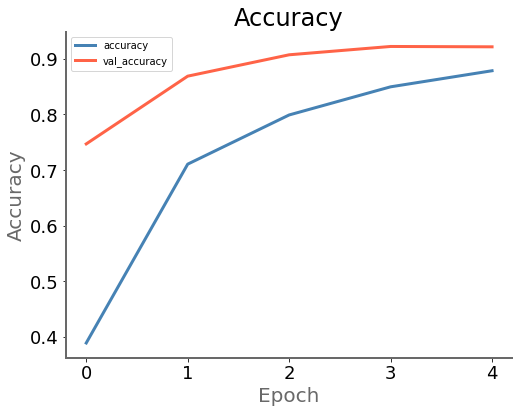

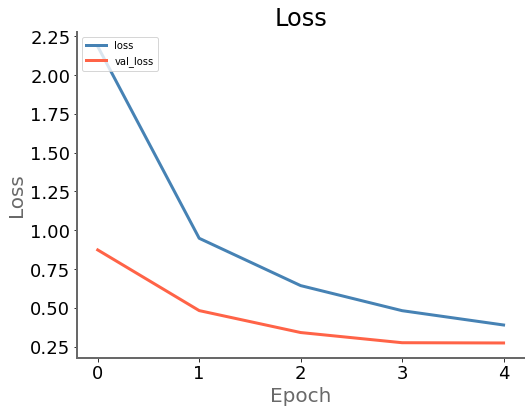

In [13]:
pwk.plot_history(history, save_as='01-history')

## Step 8 - Evaluate best model

### 8.1 - Restore best model :

In [14]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


### 8.2 - Evaluate it :

In [15]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2734
Test accuracy  : 0.9213


**Plot confusion matrix**

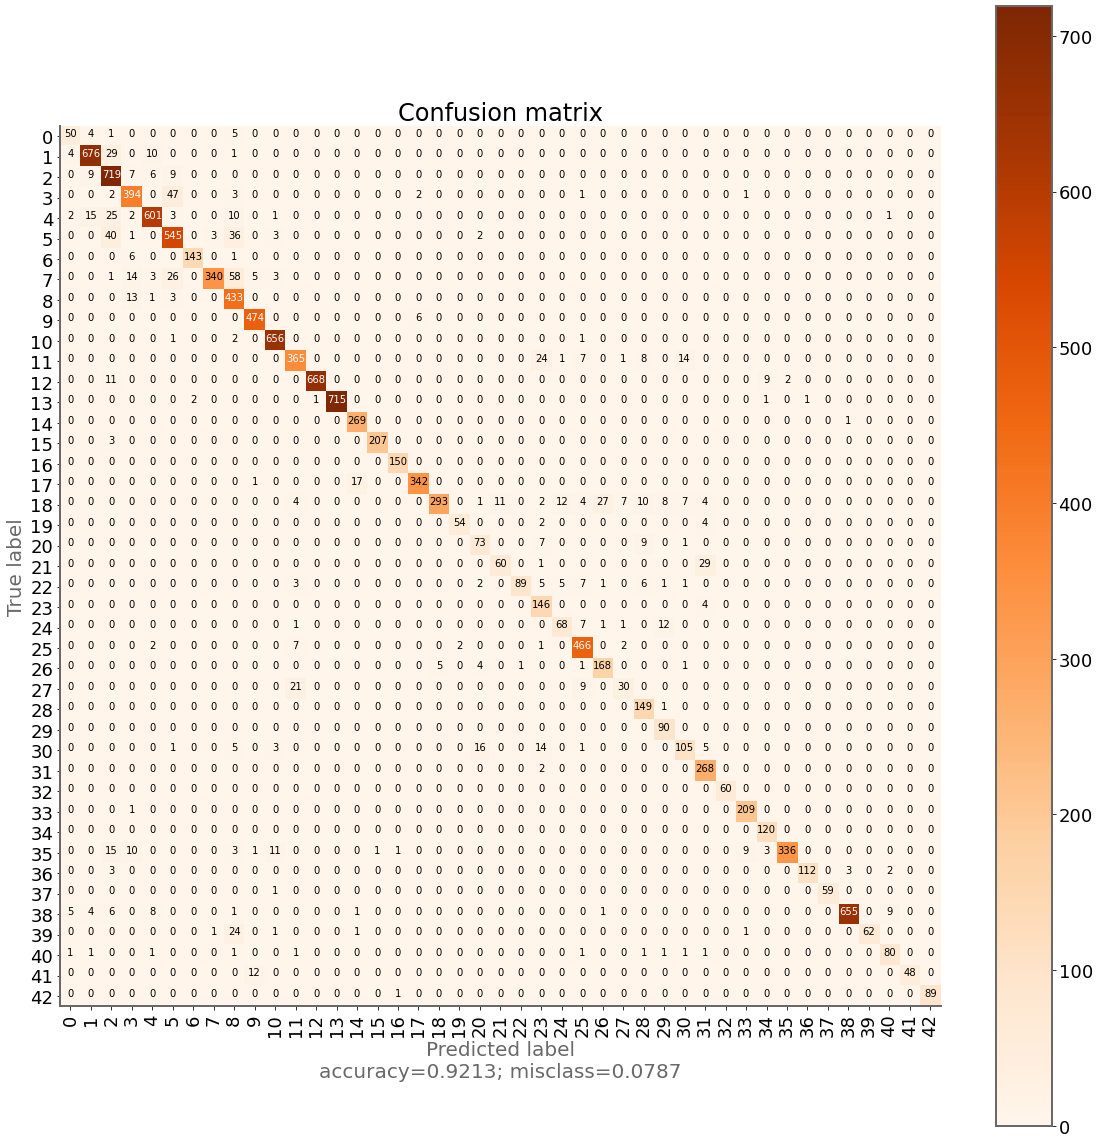

In [16]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

cmap = plt.get_cmap('Oranges')
pwk.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, cmap=cmap, save_as='02-confusion-matrix')

In [17]:
pwk.end()

End time is : Wednesday 10 February 2021, 09:19:55
Duration is : 00:01:33 606ms
This notebook ends here


<div class="todo">
     What you can do:
    <ul>
        <li>Try different datasets / models</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>What's the best strategy?  How to compare?</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>